In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/ferys2195/Dataset/main/Emotion_classify_Data.csv'
df = pd.read_csv(url)
len(df)

5937

In [3]:
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [4]:
text_column = 'Comment'
label_column = 'Emotion'

# Mengatur Dataset

In [5]:
df = df[[text_column,label_column]]
df

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
...,...,...
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear


## Exploratory Dataset

Cek Missing Value

In [6]:
df.isna().sum()

Comment    0
Emotion    0
dtype: int64

Cek Duplikasi data

In [7]:
print(df.duplicated().sum())

0



## Cleaning Dataset

Ubah nilai pada **label_column** menjadi kolom

In [8]:
rating = pd.get_dummies(df[label_column])
df_baru = pd.concat([df,rating], axis=1)
df_baru = df_baru.drop(columns=label_column)
df_baru

,Comment,anger,fear,joy
0,i seriously hate one subject to death but now ...,0,1,0
1,im so full of life i feel appalled,1,0,0
2,i sit here to write i start to dig out my feel...,0,1,0
3,ive been really angry with r and i feel like a...,0,0,1
4,i feel suspicious if there is no one outside l...,0,1,0
...,...,...,...,...
5932,i begun to feel distressed for you,0,1,0
5933,i left feeling annoyed and angry thinking that...,1,0,0
5934,i were to ever get married i d have everything...,0,0,1
5935,i feel reluctant in applying there because i w...,0,1,0


Atur nilai text dan label menjadi tipe data numpy array

In [9]:
text = df_baru[text_column].values
label = df_baru[df[label_column].unique().tolist()].values


Bagi dataset dengan porsi 80% untuk training dan 20% untuk test (80:20)

In [10]:
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

In [11]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
# Define the tokenizer with a regular expression for tokenization
tokenizer = nltk.RegexpTokenizer(r"\w+")
# Get the English stopwords
stop_words = set(stopwords.words('english'))
# Instantiate the Porter Stemmer
stemmer = PorterStemmer()
# Tokenize, remove stopwords, and apply stemming to the training data
text_latih = [
    [stemmer.stem(word.lower()) for word in tokenizer.tokenize(sentence) if word.lower() not in stop_words]
    for sentence in text_latih
]
# Tokenize, remove stopwords, and apply stemming to the test data
text_test = [
    [stemmer.stem(word.lower()) for word in tokenizer.tokenize(sentence) if word.lower() not in stop_words]
    for sentence in text_test
]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tetapkan jumlah kata untuk di tokenisasi

In [12]:
word_count = 4000

In [13]:
tokenizer = Tokenizer(num_words=word_count, oov_token='x')
tokenizer.fit_on_texts(text_latih)

sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)

padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

## Membangun Model

In [14]:
class_size = len(df[label_column].unique())

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=word_count, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(class_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

Buat callback untuk untuk memantau pada saat pelatihan model

In [15]:
class MonitoringTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') >= 0.99 and logs.get('val_accuracy') >= 0.99:
                print("\nAccuracy dan Validation Accuracy mencapai 90%")
                self.model.stop_training = True

es = EarlyStopping(patience = 3, start_from_epoch=15)
callback = [MonitoringTrainingCallback(), es]

Latih Model

In [16]:
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    steps_per_epoch=25,
                    verbose=2,
                    callbacks=callback)

Epoch 1/30
25/25 - 8s - loss: 1.0977 - accuracy: 0.3575 - val_loss: 1.0937 - val_accuracy: 0.4588 - 8s/epoch - 338ms/step
Epoch 2/30
25/25 - 3s - loss: 1.0712 - accuracy: 0.4948 - val_loss: 1.0262 - val_accuracy: 0.5539 - 3s/epoch - 117ms/step
Epoch 3/30
25/25 - 3s - loss: 0.8661 - accuracy: 0.6467 - val_loss: 0.7587 - val_accuracy: 0.6313 - 3s/epoch - 110ms/step
Epoch 4/30
25/25 - 4s - loss: 0.5388 - accuracy: 0.8109 - val_loss: 0.5644 - val_accuracy: 0.8098 - 4s/epoch - 164ms/step
Epoch 5/30
25/25 - 3s - loss: 0.2237 - accuracy: 0.9387 - val_loss: 0.3769 - val_accuracy: 0.8880 - 3s/epoch - 132ms/step
Epoch 6/30
25/25 - 3s - loss: 0.1059 - accuracy: 0.9747 - val_loss: 0.3785 - val_accuracy: 0.8864 - 3s/epoch - 124ms/step
Epoch 7/30
25/25 - 3s - loss: 0.0719 - accuracy: 0.9825 - val_loss: 0.4160 - val_accuracy: 0.8923 - 3s/epoch - 108ms/step
Epoch 8/30
25/25 - 2s - loss: 0.0427 - accuracy: 0.9901 - val_loss: 0.4433 - val_accuracy: 0.8914 - 2s/epoch - 75ms/step
Epoch 9/30
25/25 - 2s - l

## Hasil

### Nilai Akurasi dan Validation Akurasi tertinggi

In [17]:
max_accuracy = max(history.history['accuracy'])
max_val_accuracy = max(history.history['val_accuracy'])
print(f"Max Accuracy : {round(max_accuracy, 4)}")
print(f"Max Validation Accuracy : {round(max_val_accuracy, 4)}")

Max Accuracy : 0.9983
Max Validation Accuracy : 0.9007


### Grafik Pelatihan Model

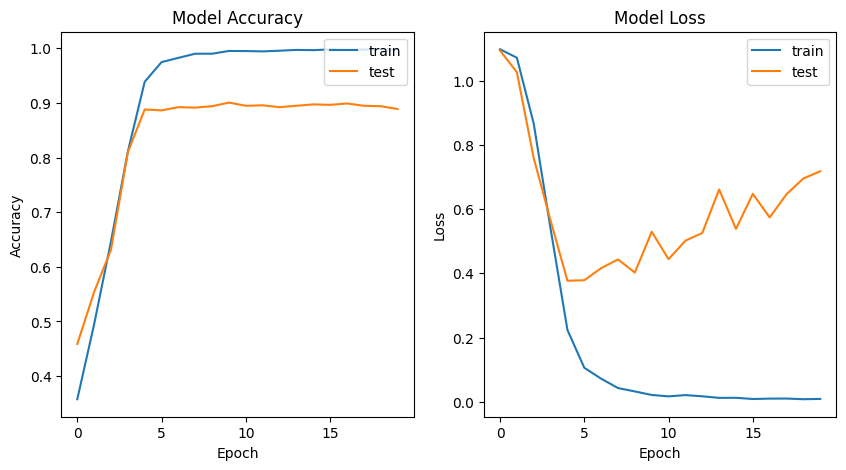

In [26]:
# Membuat subplot dengan lebar yang berbeda
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1]})

# Plot Accuracy di subplot pertama
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'test'], loc='upper right')

# Plot Loss di subplot kedua
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'test'], loc='upper right')

plt.show()
